Epoch 1/20: 100%|██████████| 782/782 [02:46<00:00,  4.70it/s]


Epoch 1, Loss: 0.6398


Epoch 2/20: 100%|██████████| 782/782 [00:44<00:00, 17.55it/s]


Epoch 2, Loss: 0.0539


Epoch 3/20: 100%|██████████| 782/782 [00:35<00:00, 22.00it/s]


Epoch 3, Loss: 0.0355


Epoch 4/20: 100%|██████████| 782/782 [00:49<00:00, 15.94it/s]


Epoch 4, Loss: 0.0293


Epoch 5/20: 100%|██████████| 782/782 [00:45<00:00, 17.15it/s]


Epoch 5, Loss: 0.0256


Epoch 6/20: 100%|██████████| 782/782 [00:48<00:00, 16.09it/s]


Epoch 6, Loss: 0.0239


Epoch 7/20: 100%|██████████| 782/782 [00:51<00:00, 15.22it/s]


Epoch 7, Loss: 0.0231


Epoch 8/20: 100%|██████████| 782/782 [00:49<00:00, 15.70it/s]


Epoch 8, Loss: 0.0223


Epoch 9/20: 100%|██████████| 782/782 [00:53<00:00, 14.66it/s]


Epoch 9, Loss: 0.0216


Epoch 10/20: 100%|██████████| 782/782 [00:55<00:00, 14.19it/s]


Epoch 10, Loss: 0.0211


Epoch 11/20: 100%|██████████| 782/782 [00:55<00:00, 14.10it/s]


Epoch 11, Loss: 0.0205


Epoch 12/20: 100%|██████████| 782/782 [00:55<00:00, 14.21it/s]


Epoch 12, Loss: 0.0199


Epoch 13/20: 100%|██████████| 782/782 [00:51<00:00, 15.18it/s]


Epoch 13, Loss: 0.0196


Epoch 14/20: 100%|██████████| 782/782 [00:52<00:00, 14.79it/s]


Epoch 14, Loss: 0.0194


Epoch 15/20: 100%|██████████| 782/782 [00:54<00:00, 14.34it/s]


Epoch 15, Loss: 0.0190


Epoch 16/20: 100%|██████████| 782/782 [00:44<00:00, 17.71it/s]


Epoch 16, Loss: 0.0187


Epoch 17/20: 100%|██████████| 782/782 [00:36<00:00, 21.26it/s]


Epoch 17, Loss: 0.0185


Epoch 18/20: 100%|██████████| 782/782 [00:37<00:00, 20.83it/s]


Epoch 18, Loss: 0.0183


Epoch 19/20: 100%|██████████| 782/782 [00:38<00:00, 20.54it/s]


Epoch 19, Loss: 0.0181


Epoch 20/20: 100%|██████████| 782/782 [00:37<00:00, 20.61it/s]


Epoch 20, Loss: 0.0179


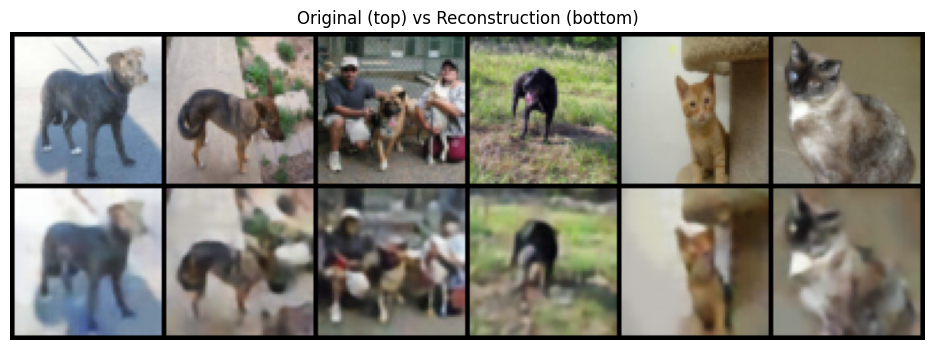

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets.folder import default_loader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm import tqdm

# === KONFIGURACJA ===
DATA_DIR = "./data/train"
IMG_SIZE = 64
BATCH_SIZE = 32
EPOCHS = 20
LR = 2e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# === DANE ===
class SimpleImageDataset(Dataset):
    def __init__(self, folder, transform):
        self.paths = [os.path.join(folder, f) for f in os.listdir(folder) if ('cat' in f or 'dog' in f)]
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = default_loader(self.paths[idx]).convert("RGB")
        return self.transform(img)

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
dataset = SimpleImageDataset(DATA_DIR, transform)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# === ENKODER / DEKODER ===
class Encoder(nn.Module):
    def __init__(self, in_channels=3, hidden_dim=128, z_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(hidden_dim, z_dim, 1)
        )

    def forward(self, x):
        return self.net(x)

class Decoder(nn.Module):
    def __init__(self, z_dim=64, hidden_dim=128, out_channels=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, hidden_dim, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(hidden_dim, hidden_dim, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(hidden_dim, out_channels, 3, 1, 1)
        )

    def forward(self, x):
        return self.net(x)

# === VQ MODUŁ ===
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1/num_embeddings, 1/num_embeddings)
        self.beta = beta

    def forward(self, z):
        z_perm = z.permute(0, 2, 3, 1).contiguous()
        flat_z = z_perm.view(-1, z.shape[1])

        dists = (
            flat_z.pow(2).sum(1, keepdim=True)
            - 2 * flat_z @ self.embedding.weight.t()
            + self.embedding.weight.pow(2).sum(1)
        )
        indices = dists.argmin(1)
        quantized = self.embedding(indices).view(z_perm.shape)
        quantized = quantized.permute(0, 3, 1, 2)

        loss = F.mse_loss(quantized.detach(), z) + self.beta * F.mse_loss(quantized, z.detach())
        quantized = z + (quantized - z).detach()
        return quantized, loss

# === MODEL VQ-VAE ===
class VQVAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.vq = VectorQuantizer(num_embeddings=512, embedding_dim=64)
        self.decoder = Decoder()

    def forward(self, x):
        z = self.encoder(x)
        quantized, loss_vq = self.vq(z)
        recon = self.decoder(quantized)
        return recon, loss_vq

# === TRENING ===
model = VQVAE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for x in tqdm(loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        x = x.to(DEVICE)
        recon, loss_vq = model(x)
        recon_loss = F.mse_loss(recon, x)
        loss = recon_loss + loss_vq

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(loader):.4f}")

# === WIZUALIZACJA ===
model.eval()
with torch.no_grad():
    imgs = next(iter(loader)).to(DEVICE)
    recon, _ = model(imgs)
    imgs = imgs[:6]
    recon = recon[:6]
    def denorm(x): return (x * 0.5 + 0.5).clamp(0, 1)

    grid = make_grid(torch.cat([denorm(imgs), denorm(recon)]), nrow=6)
    plt.figure(figsize=(12, 4))
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.axis("off")
    plt.title("Original (top) vs Reconstruction (bottom)")
    plt.show()
